# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [5]:
# Download the dataset
# This cell has to run only once. 
# NO need to run every time you arrive on this notebook. 

import requests
import tarfile
import os
import shutil

# Define the URL and folder paths
url = "https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz"
folder_name = "flowers"
file_name = "flower_data.tar.gz"
file_path = os.path.join(folder_name, file_name)

# Remove the folder or symbolic link if it already exists (equivalent to `rm -rf flowers`)
try:
    if os.path.islink(folder_name) or os.path.isfile(folder_name):
        os.remove(folder_name)  # Remove the symbolic link or file
    elif os.path.isdir(folder_name):
        shutil.rmtree(folder_name)  # Remove the directory
    print(f"Removed existing {folder_name} folder/file/soft link, if any.")
except FileNotFoundError:
    pass  # If the file or directory does not exist, do nothing

# Create the folder
os.makedirs(folder_name)
print(f"Created folder: {folder_name}")

# Download the file
response = requests.get(url, stream=True)

# Save the file in the 'flowers' folder
with open(file_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"Downloaded {file_name} to {folder_name}")

# Extract the file in the 'flowers' folder
if file_path.endswith("tar.gz"):
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=folder_name)
        print(f"Extracted {file_name} to {folder_name}")

# Clean up by removing the tar.gz file after extraction
os.remove(file_path)
print(f"Removed the downloaded tar.gz file: {file_path}")


Removed existing flowers folder/file/soft link, if any.
Created folder: flowers
Downloaded flower_data.tar.gz to flowers
Extracted flower_data.tar.gz to flowers
Removed the downloaded tar.gz file: flowers/flower_data.tar.gz


In [6]:
# Imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import torch
import time
from torch import nn
from torch import optim
import torch.nn.functional as F
import time
from torchvision import datasets, transforms, models
import json
from PIL import Image


## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/master/torchvision/transforms.html#)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. This converts the values of each color channel to be between -1 and 1 instead of 0 and 1.

In [7]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [8]:
# TODO: Define your transforms for the training, validation, and testing sets
#data_transforms = 
train_transforms = transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_transforms = test_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

validation_transforms = valid_transforms = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

# TODO: Load the datasets with ImageFolder
#image_datasets = 
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=valid_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)
# TODO: Using the image datasets and the trainforms, define the dataloaders
#dataloaders = 
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=32)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

image_datasets = [train_dataset, valid_dataset, test_dataset]
dataloaders = [trainloader, validloader, testloader]

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [9]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [10]:
# TODO: Build and train your network
def setup_network(arch='vgg16_bn', dropout=0.05, hidden_units=4096, lr=0.001, device='cuda'):
    """
    Sets up a pre-trained model and replaces the classifier.

    Parameters:
    arch (str): Model architecture ('vgg16_bn', 'resnet50', etc.).
    dropout (float): Dropout probability.
    hidden_units (int): Number of hidden units in the classifier.
    lr (float): Learning rate.
    device (str): 'cuda' or 'cpu'.

    Returns:
    model (torch.nn.Module): The constructed model.
    criterion (nn.Module): Loss function (Negative Log Likelihood).
    optimizer (torch.optim): Optimizer (Adam).
    """

    # Choose model architecture
    if arch == 'vgg16_bn':
        model = models.vgg16_bn(pretrained=True)
        input_size = 25088
    elif arch == 'resnet50':
        model = models.resnet50(pretrained=True)
        input_size = 2048
    else:
        raise ValueError("Supported architectures: 'vgg16_bn', 'resnet50'")

    # Freeze pre-trained model parameters
    for param in model.parameters():
        param.requires_grad = False

    # Define a new classifier
    classifier = nn.Sequential(OrderedDict([
        ('fc1', nn.Linear(input_size, hidden_units)),
        ('relu1', nn.ReLU()),
        ('dropout1', nn.Dropout(dropout)),
        ('fc2', nn.Linear(hidden_units, 102)),  # 102 classes for flowers dataset
        ('output', nn.LogSoftmax(dim=1))
    ]))

    # Replace the model's classifier
    model.classifier = classifier

    # Define loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=lr)

    # Move model to the selected device
    model.to(device)

    return model, criterion, optimizer

In [11]:
#training the model
def train_model(model, trainloader, validloader, criterion, optimizer, epochs=10, print_every=20, device='cuda'):
    """
    Trains a deep learning model and prints training/validation stats.

    Parameters:
    model (torch.nn.Module): The model to train.
    trainloader (torch.utils.data.DataLoader): Training dataset loader.
    validloader (torch.utils.data.DataLoader): Validation dataset loader.
    criterion (nn.Module): Loss function.
    optimizer (torch.optim): Optimizer.
    epochs (int): Number of training epochs.
    print_every (int): Number of batches before printing stats.
    device (str): 'cuda' or 'cpu'.
    """
    
    model.to(device)
    train_losses, valid_losses = [], []

    print("-- Training Started --")
    for epoch in range(epochs):
        running_loss = 0
        running_accuracy = 0
        model.train()

        for batch_idx, (images, labels) in enumerate(trainloader, 1):  # Start index from 1
            start_time = time.time()

            # Move data to the appropriate device
            images, labels = images.to(device), labels.to(device)

            # Zero gradients, forward pass, compute loss
            optimizer.zero_grad()
            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            loss.backward()
            optimizer.step()

            # Calculate training accuracy
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy = equals.float().mean()

            # Accumulate loss and accuracy
            running_loss += loss.item()
            running_accuracy += accuracy.item()

            # Print progress every 'print_every' batches
            if batch_idx % print_every == 0:
                validation_loss, validation_accuracy = validate_model(model, validloader, criterion, device)
                train_losses.append(running_loss / print_every)
                valid_losses.append(validation_loss)

                print(f"Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(trainloader)}")
                print(f"Train Loss: {running_loss/print_every:.4f} | Train Acc: {running_accuracy/print_every*100:.2f}%")
                print(f"Valid Loss: {validation_loss:.4f} | Valid Acc: {validation_accuracy:.2f}%")
                print(f"Time per batch: {time.time() - start_time:.3f} sec\n")

                running_loss = 0
                running_accuracy = 0

    print("-- Training Completed --")

def validate_model(model, validloader, criterion, device='cuda'):
    """
    Runs model evaluation on the validation set.

    Parameters:
    model (torch.nn.Module): The trained model.
    validloader (torch.utils.data.DataLoader): Validation dataset loader.
    criterion (nn.Module): Loss function.
    device (str): 'cuda' or 'cpu'.

    Returns:
    valid_loss (float): Average validation loss.
    valid_accuracy (float): Average validation accuracy.
    """
    
    model.eval()
    valid_loss = 0
    valid_accuracy = 0

    with torch.no_grad():
        for images, labels in validloader:
            images, labels = images.to(device), labels.to(device)

            log_ps = model.forward(images)
            loss = criterion(log_ps, labels)
            valid_loss += loss.item()

            # Calculate accuracy
            ps = torch.exp(log_ps)
            top_ps, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            valid_accuracy += equals.float().mean().item()

    return valid_loss / len(validloader), (valid_accuracy / len(validloader)) * 100


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [12]:
# TODO: Do validation on the test set


def test_model(model, testloader, device='cuda'):
    """
    Evaluates the trained model on the test dataset.

    Parameters:
    model (torch.nn.Module): The trained model.
    testloader (torch.utils.data.DataLoader): Test dataset loader.
    device (str): 'cuda' or 'cpu'.

    Returns:
    None
    """
    # Move model to the selected device
    model.to(device)

    # Initialize test accuracy
    test_accuracy = 0

    # Start time tracking
    start_time = time.time()
    print("Validation started on the test dataset...")

    # Set model to evaluation mode (no gradient calculation)
    model.eval()

    with torch.no_grad():  # No need to calculate gradients
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            log_ps = model.forward(images)
            ps = torch.exp(log_ps)  # Convert log probabilities to actual probabilities

            # Get top prediction
            top_ps, top_class = ps.topk(1, dim=1)
            matches = (top_class == labels.view(*top_class.shape)).type(torch.FloatTensor)

            # Compute batch accuracy
            test_accuracy += matches.mean().item()

    # End time tracking
    end_time = time.time()
    validation_time = end_time - start_time
    return test_accuracy / len(testloader) * 100, validation_time




In [13]:
# Create and define the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, criterion, optimizer = setup_network(device=device)
print("Model was setup successfuly")

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /home/student/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 68.2MB/s] 


Model was setup successfuly


In [14]:
train_model(model, trainloader, validloader, criterion, optimizer, epochs=3, device=device)

-- Training Started --
Epoch 1/3 | Batch 20/103
Train Loss: 4.9688 | Train Acc: 12.42%
Valid Loss: 3.1588 | Valid Acc: 32.68%
Time per batch: 140.510 sec

Epoch 1/3 | Batch 40/103
Train Loss: 2.7181 | Train Acc: 40.70%
Valid Loss: 1.7473 | Valid Acc: 56.74%
Time per batch: 143.659 sec

Epoch 1/3 | Batch 60/103
Train Loss: 1.8340 | Train Acc: 54.77%
Valid Loss: 1.1428 | Valid Acc: 68.91%
Time per batch: 140.550 sec

Epoch 1/3 | Batch 80/103
Train Loss: 1.3305 | Train Acc: 65.31%
Valid Loss: 0.9054 | Valid Acc: 74.05%
Time per batch: 145.097 sec

Epoch 1/3 | Batch 100/103
Train Loss: 1.1356 | Train Acc: 70.55%
Valid Loss: 0.5709 | Valid Acc: 84.43%
Time per batch: 143.160 sec

Epoch 2/3 | Batch 20/103
Train Loss: 0.9516 | Train Acc: 74.38%
Valid Loss: 0.5964 | Valid Acc: 83.11%
Time per batch: 149.356 sec

Epoch 2/3 | Batch 40/103
Train Loss: 0.8123 | Train Acc: 78.44%
Valid Loss: 0.5312 | Valid Acc: 84.67%
Time per batch: 163.398 sec

Epoch 2/3 | Batch 60/103
Train Loss: 0.8320 | Train 

KeyboardInterrupt: 

In [15]:
#Run the function and store outputs
test_acc, val_time = test_model(model, testloader, device)

#Print variables separately if needed
print(f"Stored Test Accuracy: {test_acc:.2f}%")
print(f"Stored Validation Time: {int(val_time // 60)}m {int(val_time % 60)}s")

Validation started on the test dataset...
Stored Test Accuracy: 86.85%
Stored Validation Time: 2m 46s


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [17]:
# TODO: Save the checkpoint 
checkpoint_path = "flower_classifier.pth"
torch.save({
    'state_dict': model.state_dict(),
    'class_to_idx': train_dataset.class_to_idx
}, checkpoint_path)

print(f"Model saved at {checkpoint_path}")

Model saved at flower_classifier.pth


## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [11]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_model(checkpoint_path, model):
    """
    Loads a trained model from a checkpoint file.

    Parameters:
    checkpoint_path (str): Path to the saved checkpoint.
    model (torch.nn.Module): Model instance to load state into.

    Returns:
    model (torch.nn.Module): Model with loaded weights.
    """
    checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
    
    model.load_state_dict(checkpoint['state_dict'])
    model.class_to_idx = checkpoint['class_to_idx']

    print(f"Model loaded from '{checkpoint_path}'")
    return model


In [12]:
model, criterion, optimizer = setup_network(device=device)
model = load_model("flower_classifier.pth", model)

Model loaded from 'flower_classifier.pth'


# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [14]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    """
    Preprocesses an image for a PyTorch model.

    Parameters:
    image_path (str): Path to the image.

    Returns:
    np.array: Processed image as a NumPy array.
    """
    # Open image and convert to RGB
    image = Image.open(image).convert("RGB")

    # Resize: Maintain aspect ratio (shortest side = 256px)
    size = 256
    aspect_ratio = max(image.size) / min(image.size)

    if image.width < image.height:
        new_size = (size, int(size * aspect_ratio))
    else:
        new_size = (int(size * aspect_ratio), size)

    image = image.resize(new_size)

    # Center crop to 224x224 pixels
    crop_size = 224
    width, height = image.size
    left = (width - crop_size) / 2
    top = (height - crop_size) / 2
    right = (width + crop_size) / 2
    bottom = (height + crop_size) / 2
    image = image.crop((left, top, right, bottom))

    # Convert image to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
    ])

    tensor_image = transform(image)

    # Convert tensor to numpy array
    np_image = tensor_image.numpy()
    
    return np_image


To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [15]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

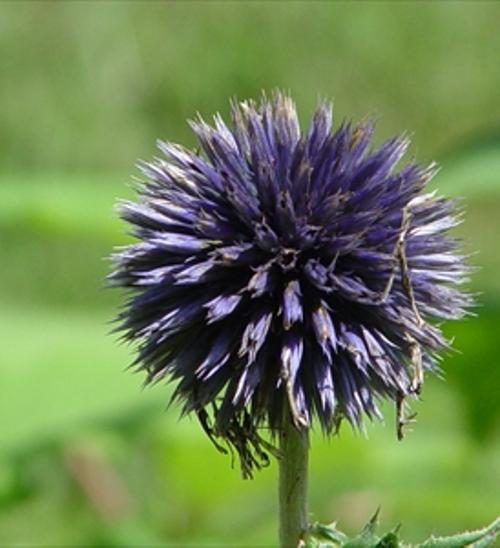

In [16]:
practice_img = './flowers/test/10/image_07104.jpg'
# display the original image
processed_image = Image.open(practice_img)
processed_image


<Axes: >

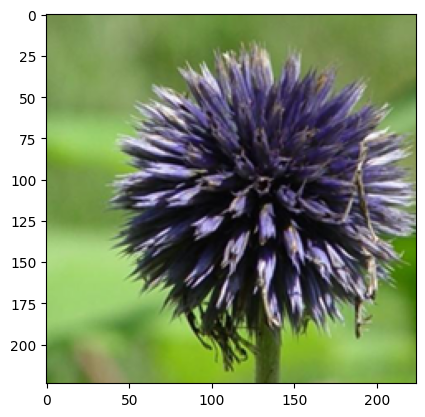

In [17]:
# display the preprocessed image
imshow(process_image(practice_img))

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [18]:
import json

def class_to_label(json_file, classes):
    """
    Converts numerical class indices to human-readable labels.

    Parameters:
    json_file (str): Path to category names JSON file.
    classes (list): List of class indices.

    Returns:
    labels (list): Mapped class names.
    """
    with open(json_file, 'r') as f:
        class_mapping = json.load(f)

    # Convert class numbers to names
    labels = [class_mapping[c] for c in classes if c in class_mapping]
    
    return labels


In [19]:
# def predict(image_path, model, topk=5):
#     ''' Predict the class (or classes) of an image using a trained deep learning model.
#     '''
    
#     # TODO: Implement the code to predict the class from an image file


def predict(image_path, model, class_to_idx, top_k=5, device="cuda"):
    """
    Predict the top K classes for an input image using a trained model.

    Parameters:
    image_path (str): Path to the image file.
    model (torch.nn.Module): The trained PyTorch model.
    class_to_idx (dict): Mapping from class indices to actual class labels.
    top_k (int): Number of top classes to return.
    device (str): 'cuda' or 'cpu'.

    Returns:
    probs (list): Top K probabilities.
    classes (list): Corresponding class labels.
    """
    # Process image
    image = process_image(image_path)
    
    # Convert numpy image to a PyTorch tensor and add batch dimension
    image_tensor = torch.from_numpy(image).unsqueeze(0).to(device).float()

    # Ensure model is on the correct device and in evaluation mode
    model.to(device)
    model.eval()

    with torch.no_grad():
        log_ps = model.forward(image_tensor)
        ps = torch.exp(log_ps)  # Convert log probabilities to actual probabilities

        # Get top K probabilities and corresponding class indices
        top_probs, top_indices = ps.topk(top_k, dim=1)

    # Convert tensors to lists
    top_probs = top_probs.cpu().numpy().flatten()
    top_indices = top_indices.cpu().numpy().flatten()

    # Invert `class_to_idx` to map indices back to class labels
    idx_mapping = {v: k for k, v in class_to_idx.items()}
    top_classes = [idx_mapping[idx] for idx in top_indices]

    return top_probs, top_classes


In [20]:
def print_predictions(probs, classes, image_path, category_names=None):
    """
    Prints the predictions of the model.

    Parameters:
    probs (list): Probabilities of the top K predictions.
    classes (list): Class labels of the top K predictions.
    image_path (str): Path to the image.
    category_names (str, optional): Path to category mapping JSON file.

    Returns:
    None
    """
    print(f"\n Predictions for: {image_path.split('/')[-1]}\n")

    if category_names:
        labels = class_to_label(category_names, classes)
        for i, (prob, label, cls) in enumerate(zip(probs, labels, classes), 1):
            print(f"{i}) {prob*100:.2f}% {label.title()} | Class No. {cls}")
    else:
        for i, (prob, cls) in enumerate(zip(probs, classes), 1):
            print(f"{i}) {prob*100:.2f}% Class No. {cls}")
    
    print("")


In [21]:
# Define image path
practice_img = "./flowers/test/100/image_07896.jpg"

# Ensure model is loaded
model, _, _ = setup_network(device=device)  # Recreate model
model = load_model("flower_classifier.pth", model)  # Load trained weights

# Run prediction
probabilities, classes = predict(practice_img, model, model.class_to_idx, top_k=5, device=device)

# Print results
print_predictions(probabilities, classes, practice_img, "cat_to_name.json")


Model loaded from 'flower_classifier.pth'

 Predictions for: image_07896.jpg

1) 99.76% Blanket Flower | Class No. 100
2) 0.17% Colt'S Foot | Class No. 12
3) 0.04% Sunflower | Class No. 54
4) 0.02% Purple Coneflower | Class No. 17
5) 0.01% Gazania | Class No. 71



## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

In [ ]:
# TODO: Display an image along with the top 5 classes

In [22]:

def plot_predictions(image_path, model, class_to_idx, category_names, top_k=5, device="cuda"):
    """
    Displays the input image and a bar chart of the top K class predictions.

    Parameters:
    image_path (str): Path to the input image.
    model (torch.nn.Module): The trained PyTorch model.
    class_to_idx (dict): Mapping from class indices to actual class labels.
    category_names (str): Path to category mapping JSON file.
    top_k (int): Number of top predictions to display.
    device (str): 'cuda' or 'cpu'.

    Returns:
    None
    """
    # Run the prediction
    probs, classes = predict(image_path, model, class_to_idx, top_k=top_k, device=device)

    # Convert class indices to flower names
    labels = class_to_label(category_names, classes)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 8), nrows=2)

    # Display the input image
    image = process_image(image_path)
    imshow(image, ax=ax1, title="Input Image")

    # Create the bar chart
    ax2.barh(labels, probs, color="blue")
    ax2.set_xlabel("Probability")
    ax2.set_title("Model Predictions")
    ax2.invert_yaxis()  # Invert y-axis to match highest probability at top

    plt.tight_layout()
    plt.show()


Model loaded from 'flower_classifier.pth'


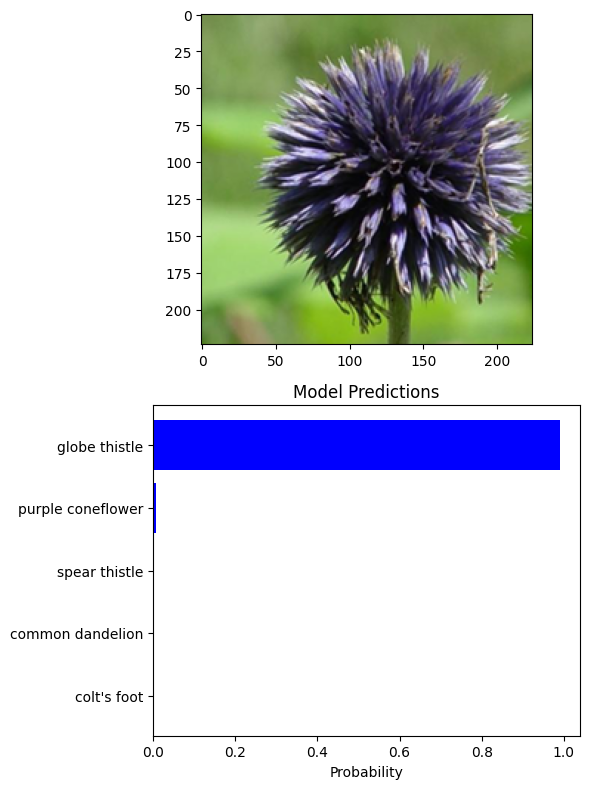

In [23]:
# Define test image path
test_image = "./flowers/test/10/image_07104.jpg"

# Load model
model, _, _ = setup_network(device=device)  # Create model
model = load_model("flower_classifier.pth", model)  # Load trained weights

# Run sanity check
plot_predictions(test_image, model, model.class_to_idx, "cat_to_name.json", top_k=5, device=device)


In [15]:
!python train.py flowers --arch vgg16 --epochs 5 --learning_rate 0.001 --save_dir saved_models --gpu


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

Starting training on CUDA...
Epoch 1/5.. Train Loss: 2.351.. Validation Loss: 0.721.. Validation Accuracy: 81.22%
Epoch 2/5.. Train Loss: 1.128.. Validation Loss: 0.583.. Validation Accuracy: 84.26%
Epoch 3/5.. Train Loss: 0.922.. Validation Loss: 0.461.. Validation Accuracy: 87.19%
Epoch 4/5.. Train Loss: 0.831.. Validation Loss: 0.447.. Validation Accuracy: 86.96%
Epoch 5/5.. T

In [16]:
!python predict.py flowers/test/19/image_06186.jpg saved_models/checkpoint_vgg16.pth



Predictions:
1) balloon flower - 95.55%
2) petunia - 4.11%
3) clematis - 0.23%
4) morning glory - 0.04%
5) wild pansy - 0.02%

Prediction process completed.
